In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import sklearn
import cv2
import scipy
import keras
import glob
import os
import cv2

Using TensorFlow backend.


In [2]:
print("CV2", cv2.__version__)
print("Tensorflow",tf.__version__)
print("Numpy",np.__version__)
print("sklearn",sklearn.__version__)
print("scipy",scipy.__version__)
print("keras",keras.__version__)

CV2 4.4.0
Tensorflow 1.14.0
Numpy 1.19.1
sklearn 0.20.0
scipy 1.5.2
keras 2.3.1


In [3]:
file_list = glob.glob("./modified_data/*")
print(len(file_list), "number of files")

2790 number of files


In [4]:
# Reading our training CSV file
with open("./train_data.csv", "r") as f:
    lines = f.readlines()
    
dataset = []

for line in lines[1:]:
    
    sline = line.strip().split(",")
    dataset.append({
        "file": sline[0],
        "person_id": int(sline[1]),
        "series": int(sline[2]),
        "tilt": int(sline[3]),
        "pan": int(sline[4])
    })

In [5]:
# Displaying tilt and pan angles
tilts = [item["tilt"] for item in dataset]
pans = [item["pan"] for item in dataset]

all_tilts = np.unique(tilts)
all_pans = np.unique(pans)

print ("Tilt angles : ", all_tilts)
print ("Pan angles : ", all_pans)

Tilt angles :  [-90 -60 -30 -15   0  15  30  60  90]
Pan angles :  [-90 -75 -60 -45 -30 -15   0  15  30  45  60  75  90]


# Group Classes

In [6]:
# Grouping tilt and pan angle
grouped_classes = {}
class_groups = {}
class_counter = 0

for tilt in all_tilts:
    grouped_classes[tilt] = {}
    for pan in all_pans:
        grouped_classes[tilt][pan] = class_counter
        class_groups[class_counter] = {"tilt": tilt, "pan": pan}
        class_counter+=1
        
class_groups

{0: {'tilt': -90, 'pan': -90},
 1: {'tilt': -90, 'pan': -75},
 2: {'tilt': -90, 'pan': -60},
 3: {'tilt': -90, 'pan': -45},
 4: {'tilt': -90, 'pan': -30},
 5: {'tilt': -90, 'pan': -15},
 6: {'tilt': -90, 'pan': 0},
 7: {'tilt': -90, 'pan': 15},
 8: {'tilt': -90, 'pan': 30},
 9: {'tilt': -90, 'pan': 45},
 10: {'tilt': -90, 'pan': 60},
 11: {'tilt': -90, 'pan': 75},
 12: {'tilt': -90, 'pan': 90},
 13: {'tilt': -60, 'pan': -90},
 14: {'tilt': -60, 'pan': -75},
 15: {'tilt': -60, 'pan': -60},
 16: {'tilt': -60, 'pan': -45},
 17: {'tilt': -60, 'pan': -30},
 18: {'tilt': -60, 'pan': -15},
 19: {'tilt': -60, 'pan': 0},
 20: {'tilt': -60, 'pan': 15},
 21: {'tilt': -60, 'pan': 30},
 22: {'tilt': -60, 'pan': 45},
 23: {'tilt': -60, 'pan': 60},
 24: {'tilt': -60, 'pan': 75},
 25: {'tilt': -60, 'pan': 90},
 26: {'tilt': -30, 'pan': -90},
 27: {'tilt': -30, 'pan': -75},
 28: {'tilt': -30, 'pan': -60},
 29: {'tilt': -30, 'pan': -45},
 30: {'tilt': -30, 'pan': -30},
 31: {'tilt': -30, 'pan': -15},
 3

In [7]:
# Storing image path and their tilt and pan angle in lists respectively
x_data = []
y_data = []

for item in dataset:
    x_data.append(item["file"])
    y_data.append(grouped_classes[item["tilt"]][item["pan"]])

x_data, y_data

(['face_790.jpg',
  'face_2445.jpg',
  'face_2266.jpg',
  'face_2713.jpg',
  'face_2016.jpg',
  'face_2522.jpg',
  'face_1254.jpg',
  'face_2754.jpg',
  'face_201.jpg',
  'face_931.jpg',
  'face_260.jpg',
  'face_136.jpg',
  'face_2194.jpg',
  'face_1921.jpg',
  'face_203.jpg',
  'face_1795.jpg',
  'face_511.jpg',
  'face_1906.jpg',
  'face_1348.jpg',
  'face_1324.jpg',
  'face_2216.jpg',
  'face_1808.jpg',
  'face_1998.jpg',
  'face_2070.jpg',
  'face_1603.jpg',
  'face_801.jpg',
  'face_2726.jpg',
  'face_1883.jpg',
  'face_173.jpg',
  'face_1647.jpg',
  'face_2593.jpg',
  'face_1389.jpg',
  'face_1258.jpg',
  'face_1689.jpg',
  'face_1813.jpg',
  'face_2193.jpg',
  'face_1357.jpg',
  'face_2750.jpg',
  'face_1218.jpg',
  'face_756.jpg',
  'face_213.jpg',
  'face_946.jpg',
  'face_1277.jpg',
  'face_2332.jpg',
  'face_1047.jpg',
  'face_1548.jpg',
  'face_1238.jpg',
  'face_119.jpg',
  'face_949.jpg',
  'face_1394.jpg',
  'face_1344.jpg',
  'face_1717.jpg',
  'face_1293.jpg',
  'face

In [8]:
# Displaying no of classes after grouping our tilt and pan angles
n_classes = len(np.unique(y_data))
print("Grouped Classes : ",n_classes)

Grouped Classes :  93


# Grouped Classification Model

In [9]:
# Splitting our data for training and valdiation
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

In [10]:
# Displaying our training and validation data count
print ('x_train : ', len(x_train))
print ('y_train : ', len(y_train))
print ('x_test : ', len(x_test))
print ('y_test : ', len(y_test))

x_train :  2092
y_train :  2092
x_test :  233
y_test :  233


### Data PreProcessing and Creating Data Directories

In [73]:
# Resizing our training images
images_base_dir = "modified_data/"
save_dir = "grouped_data/"

os.makedirs(save_dir, exist_ok=True)

for imgName, imgClass in zip(x_train, y_train):
    dataimg = cv2.imread(images_base_dir + imgName)
    dataimg = cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB)
    dataimg = cv2.resize(dataimg, (224, 224))
    
    os.makedirs( save_dir + "train/%d/" % imgClass, exist_ok=True)
    cv2.imwrite(save_dir + "train/%d/%s" % (imgClass, imgName), dataimg)


In [74]:
# Resizing our validation images
for imgName, imgClass in zip(x_test, y_test):
    dataimg = cv2.imread(images_base_dir + imgName)
    dataimg = cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB)
    dataimg = cv2.resize(dataimg, (224, 224))
    
    os.makedirs( save_dir + "test/%d/" % imgClass, exist_ok=True)
    cv2.imwrite(save_dir + "test/%d/%s" % (imgClass, imgName), dataimg)

In [20]:
# Loading mobilenetv2 model
base_model= tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False)

In [21]:
classifciation_model = base_model.output
classifciation_model = tf.keras.layers.GlobalAveragePooling2D()(classifciation_model)
classifciation_model = tf.keras.layers.Dense(1024, activation='relu')(classifciation_model)
classifciation_model = tf.keras.layers.Dropout(0.5)(classifciation_model)
classifciation_model = tf.keras.layers.Dense(512, activation='relu')(classifciation_model)
classifciation_model = tf.keras.layers.Dropout(0.5)(classifciation_model)
classifciation_model = tf.keras.layers.Dense(256, activation='relu')(classifciation_model) 
classification_out = tf.keras.layers.Dense(93, activation='softmax')(classifciation_model) 

In [22]:
groupedClassificationModel = tf.keras.Model(inputs=base_model.input,outputs=classification_out)

In [75]:
# Generate batches of tensor image data for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train_generator= train_datagen.flow_from_directory('./grouped_data/train/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2092 images belonging to 93 classes.


In [76]:
# Generate batches of tensor image data for validation
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_generator= test_datagen.flow_from_directory('./grouped_data/test/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 233 images belonging to 88 classes.


In [25]:
# Compiling and fiting our model
groupedClassificationModel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
sst=train_generator.n//train_generator.batch_size
groupedClassificationModel.fit_generator(generator=train_generator, steps_per_epoch=sst, epochs=10)

Epoch 1/10
71/71 [==============================] - 875s 12s/step - loss: 4.5619 - acc: 0.0101
Epoch 2/10
71/71 [==============================] - 849s 12s/step - loss: 4.2734 - acc: 0.0242
Epoch 3/10
71/71 [==============================] - 927s 13s/step - loss: 3.8703 - acc: 0.0401
Epoch 4/10
71/71 [==============================] - 910s 13s/step - loss: 3.4164 - acc: 0.0634
Epoch 5/10
71/71 [==============================] - 911s 13s/step - loss: 3.0074 - acc: 0.0973
Epoch 6/10
71/71 [==============================] - 1053s 15s/step - loss: 2.7597 - acc: 0.1298
Epoch 7/10
71/71 [==============================] - 901s 13s/step - loss: 2.4637 - acc: 0.1740
Epoch 8/10
71/71 [==============================] - 1001s 14s/step - loss: 2.2613 - acc: 0.2299
Epoch 9/10
71/71 [==============================] - 879s 12s/step - loss: 2.0193 - acc: 0.2676
Epoch 10/10
71/71 [==============================] - 1042s 15s/step - loss: 1.9904 - acc: 0.3119


In [26]:
# Running 30 more epochs
groupedClassificationModel.fit_generator(generator=train_generator, steps_per_epoch=sst, epochs=30)

Epoch 1/30
71/71 [==============================] - 1018s 14s/step - loss: 1.8381 - acc: 0.3329
Epoch 2/30
71/71 [==============================] - 927s 13s/step - loss: 1.7019 - acc: 0.3686
Epoch 3/30
71/71 [==============================] - 869s 12s/step - loss: 1.5690 - acc: 0.4020
Epoch 4/30
71/71 [==============================] - 963s 14s/step - loss: 1.4945 - acc: 0.4340
Epoch 5/30
71/71 [==============================] - 909s 13s/step - loss: 1.5014 - acc: 0.4313
Epoch 6/30
71/71 [==============================] - 876s 12s/step - loss: 1.4148 - acc: 0.4646
Epoch 7/30
71/71 [==============================] - 779s 11s/step - loss: 1.3397 - acc: 0.4857
Epoch 8/30
71/71 [==============================] - 756s 11s/step - loss: 1.2646 - acc: 0.5090
Epoch 9/30
71/71 [==============================] - 800s 11s/step - loss: 1.2244 - acc: 0.5429
Epoch 10/30
71/71 [==============================] - 929s 13s/step - loss: 1.0971 - acc: 0.5707
Epoch 11/30
71/71 [=============================

In [27]:
# Running 30 more epochs
groupedClassificationModel.fit_generator(generator=train_generator, steps_per_epoch=sst, epochs=30)

Epoch 1/30
71/71 [==============================] - 755s 11s/step - loss: 0.4732 - acc: 0.8261
Epoch 2/30
71/71 [==============================] - 752s 11s/step - loss: 0.5346 - acc: 0.8071
Epoch 3/30
71/71 [==============================] - 754s 11s/step - loss: 0.5420 - acc: 0.7917
Epoch 4/30
71/71 [==============================] - 754s 11s/step - loss: 0.4814 - acc: 0.8261
Epoch 5/30
71/71 [==============================] - 751s 11s/step - loss: 0.4395 - acc: 0.8446
Epoch 6/30
71/71 [==============================] - 752s 11s/step - loss: 0.5243 - acc: 0.8076
Epoch 7/30
71/71 [==============================] - 752s 11s/step - loss: 0.4444 - acc: 0.8446
Epoch 8/30
71/71 [==============================] - 754s 11s/step - loss: 0.4971 - acc: 0.8165
Epoch 9/30
71/71 [==============================] - 750s 11s/step - loss: 0.5102 - acc: 0.8198
Epoch 10/30
71/71 [==============================] - 751s 11s/step - loss: 0.5040 - acc: 0.8195
Epoch 11/30
71/71 [==============================

In [36]:
# Saving our grouped classification model to a groupedClassificationModel directory
model_dir = "groupedClassificationModel"
os.makedirs(model_dir, exist_ok=True)
groupedClassificationModel.save("%s/model.h5" % model_dir)

In [43]:
# Saving our mapping interger mapping to classes in a np file
indices_to_class = {}

for k, val in train_generator.class_indices.items():
    indices_to_class[val] = k
    
np.save("%s/mapping.np" % model_dir, indices_to_class)

In [112]:
# Predicting our trained model validation accuracy for both tilt and pan angle
tilt_accuracy = 0
pan_accuracy = 0

for x, y in zip(x_test, y_test):
        
    predImg = cv2.imread(save_dir + "test/%d/%s" % (y, x))
    predImg = tf.keras.applications.mobilenet_v2.preprocess_input(predImg)
    pred = groupedClassificationModel.predict(np.array([predImg]))
    
    predictedClass = class_groups[int(indices_to_class[np.argmax(pred)])]
    actualClass = class_groups[y]
    
    if predictedClass["tilt"] == actualClass["tilt"]:
        tilt_accuracy+=1
    if predictedClass["pan"] == actualClass["pan"]:
        pan_accuracy+=1
        
        
print("Tilt accuracy", tilt_accuracy / len(y_test) * 100)
print("Pan accuracy", pan_accuracy / len(y_test) * 100)

Tilt accuracy 35.060706553
Pan accuracy 36.32452235


# Two classification models

In [86]:
# Storing image path and their tilt and pan angle in lists respectively
x_data = []
y_data = []

for item in dataset:
    x_data.append(item["file"])
    y_data.append({"tilt": item["tilt"], "pan" : item["pan"]})

y_data

[{'tilt': -15, 'pan': 30},
 {'tilt': 0, 'pan': -75},
 {'tilt': -15, 'pan': -60},
 {'tilt': 0, 'pan': -90},
 {'tilt': 15, 'pan': -75},
 {'tilt': 30, 'pan': 60},
 {'tilt': 15, 'pan': -15},
 {'tilt': 15, 'pan': -45},
 {'tilt': 30, 'pan': -90},
 {'tilt': 15, 'pan': -30},
 {'tilt': -15, 'pan': 90},
 {'tilt': -60, 'pan': 15},
 {'tilt': -30, 'pan': 15},
 {'tilt': 15, 'pan': 90},
 {'tilt': 30, 'pan': -15},
 {'tilt': 15, 'pan': 45},
 {'tilt': -60, 'pan': -75},
 {'tilt': 0, 'pan': 15},
 {'tilt': 90, 'pan': 0},
 {'tilt': -60, 'pan': 60},
 {'tilt': 30, 'pan': 30},
 {'tilt': -30, 'pan': 30},
 {'tilt': -15, 'pan': 0},
 {'tilt': 0, 'pan': 30},
 {'tilt': 60, 'pan': -15},
 {'tilt': -15, 'pan': 60},
 {'tilt': -60, 'pan': -60},
 {'tilt': -30, 'pan': -15},
 {'tilt': 60, 'pan': 75},
 {'tilt': -30, 'pan': -45},
 {'tilt': 30, 'pan': -60},
 {'tilt': -30, 'pan': -75},
 {'tilt': 30, 'pan': 90},
 {'tilt': 15, 'pan': 15},
 {'tilt': 60, 'pan': 60},
 {'tilt': 60, 'pan': 30},
 {'tilt': -60, 'pan': 90},
 {'tilt': 0, 

In [87]:
# Splitting our data for training and valdiation
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

In [88]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

2092 2092 233 233


### Data PreProcessing and Creating Data Directories

In [89]:
# Resizing our training images and validation images
images_base_dir = "modified_data/"
save_dir = "bi_classification_data/"

os.makedirs(save_dir, exist_ok=True)
os.makedirs(save_dir + "/tilt/", exist_ok=True)
os.makedirs(save_dir + "/pan/", exist_ok=True)

for imgName, imgClasses in zip(x_train, y_train):
    
    dataimg = cv2.imread(images_base_dir + imgName)
    dataimg = cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB)
    dataimg = cv2.resize(dataimg, (224, 224))
    
    os.makedirs(save_dir + "tilt/train/%d/" % imgClasses["tilt"], exist_ok=True)
    cv2.imwrite(save_dir + "tilt/train/%d/%s" % (imgClasses["tilt"], imgName), dataimg)
    
    os.makedirs(save_dir + "pan/train/%d/" % imgClasses["pan"], exist_ok=True)
    cv2.imwrite(save_dir + "pan/train/%d/%s" % (imgClasses["pan"], imgName), dataimg)
    

for imgName, imgClasses in zip(x_test, y_test):
    
    dataimg = cv2.imread(images_base_dir + imgName)
    dataimg = cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB)
    dataimg = cv2.resize(dataimg, (224, 224))
    
    os.makedirs(save_dir + "tilt/test/%d/" % imgClasses["tilt"], exist_ok=True)
    cv2.imwrite(save_dir + "tilt/test/%d/%s" % (imgClasses["tilt"], imgName), dataimg)
    
    os.makedirs(save_dir + "pan/test/%d/" % imgClasses["pan"], exist_ok=True)
    cv2.imwrite(save_dir + "pan/test/%d/%s" % (imgClasses["pan"], imgName), dataimg)

In [91]:
# Loading mobilenetv2 model
base_model= tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False)
tilt_classifciation_model = base_model.output
tilt_classifciation_model = tf.keras.layers.GlobalAveragePooling2D()(tilt_classifciation_model)
tilt_classifciation_model = tf.keras.layers.Dense(256, activation='relu')(tilt_classifciation_model)
tilt_classifciation_model = tf.keras.layers.Dropout(0.5)(tilt_classifciation_model)
tilt_classifciation_model = tf.keras.layers.Dense(128, activation='relu')(tilt_classifciation_model)
tilt_classifciation_model = tf.keras.layers.Dropout(0.5)(tilt_classifciation_model)
tilt_classifciation_model = tf.keras.layers.Dense(64, activation='relu')(tilt_classifciation_model) 
tilt_classification_out = tf.keras.layers.Dense(len(all_tilts), activation='softmax')(tilt_classifciation_model) 

C:\Users\imtin\anaconda3\envs\ds-env\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [92]:
tiltClassificationModel = tf.keras.Model(inputs=base_model.input,outputs=tilt_classification_out)

In [93]:
# Generate batches of tensor image data for training
tilt_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
tilt_train_generator= tilt_train_datagen.flow_from_directory('./bi_classification_data/tilt/train/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2092 images belonging to 9 classes.


In [94]:
# Compiling and fiting our model
tiltClassificationModel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
sst=tilt_train_generator.n//tilt_train_generator.batch_size
tiltClassificationModel.fit_generator(generator=tilt_train_generator, steps_per_epoch=sst, epochs=1)

65/65 [==============================] - 765s 12s/step - loss: 1.8161 - acc: 0.2917


In [95]:
# Running 5 more epochs
tiltClassificationModel.fit_generator(generator=tilt_train_generator, steps_per_epoch=sst, epochs=5)

Epoch 1/5
65/65 [==============================] - 818s 13s/step - loss: 1.1254 - acc: 0.5350
Epoch 2/5
65/65 [==============================] - 791s 12s/step - loss: 0.9360 - acc: 0.6476
Epoch 3/5
65/65 [==============================] - 804s 12s/step - loss: 0.8360 - acc: 0.6879
Epoch 4/5
65/65 [==============================] - 812s 12s/step - loss: 0.5720 - acc: 0.8063
Epoch 5/5
65/65 [==============================] - 852s 13s/step - loss: 0.6321 - acc: 0.7699


In [96]:
# Running 10 more epochs
tiltClassificationModel.fit_generator(generator=tilt_train_generator, steps_per_epoch=sst, epochs=10)

Epoch 1/10
65/65 [==============================] - 767s 12s/step - loss: 0.4553 - acc: 0.8427
Epoch 2/10
65/65 [==============================] - 791s 12s/step - loss: 0.5301 - acc: 0.8150
Epoch 3/10
65/65 [==============================] - 763s 12s/step - loss: 0.5074 - acc: 0.8252
Epoch 4/10
65/65 [==============================] - 795s 12s/step - loss: 0.4161 - acc: 0.8563
Epoch 5/10
65/65 [==============================] - 796s 12s/step - loss: 0.3539 - acc: 0.8830
Epoch 6/10
65/65 [==============================] - 788s 12s/step - loss: 0.3184 - acc: 0.8942
Epoch 7/10
65/65 [==============================] - 771s 12s/step - loss: 0.2773 - acc: 0.9170
Epoch 8/10
65/65 [==============================] - 785s 12s/step - loss: 0.2263 - acc: 0.9327
Epoch 9/10
65/65 [==============================] - 766s 12s/step - loss: 0.3265 - acc: 0.8931
Epoch 10/10
65/65 [==============================] - 764s 12s/step - loss: 0.3088 - acc: 0.8990


In [107]:
# Running 10 more epochs
tiltClassificationModel.fit_generator(generator=tilt_train_generator, steps_per_epoch=sst, epochs=10)

Epoch 1/10
65/65 [==============================] - 846s 13s/step - loss: 0.3368 - acc: 0.8995
Epoch 2/10
65/65 [==============================] - 817s 13s/step - loss: 0.1518 - acc: 0.9558
Epoch 3/10
65/65 [==============================] - 822s 13s/step - loss: 0.1759 - acc: 0.9563
Epoch 4/10
65/65 [==============================] - 857s 13s/step - loss: 0.2081 - acc: 0.9437
Epoch 5/10
65/65 [==============================] - 857s 13s/step - loss: 0.1254 - acc: 0.9636
Epoch 6/10
65/65 [==============================] - 854s 13s/step - loss: 0.1314 - acc: 0.9621
Epoch 7/10
65/65 [==============================] - 865s 13s/step - loss: 0.1329 - acc: 0.9704
Epoch 8/10
65/65 [==============================] - 945s 15s/step - loss: 0.2727 - acc: 0.9218
Epoch 9/10
65/65 [==============================] - 1209s 19s/step - loss: 0.2228 - acc: 0.9393
Epoch 10/10
65/65 [==============================] - 1228s 19s/step - loss: 0.1688 - acc: 0.9481


In [111]:
# Running 5 more epochs
tiltClassificationModel.fit_generator(generator=tilt_train_generator, steps_per_epoch=sst, epochs=5)

Epoch 1/5
65/65 [==============================] - 1239s 19s/step - loss: 0.0605 - acc: 0.9850
Epoch 2/5
65/65 [==============================] - 887s 14s/step - loss: 0.0974 - acc: 0.9762
Epoch 3/5
65/65 [==============================] - 868s 13s/step - loss: 0.1476 - acc: 0.9631
Epoch 4/5
65/65 [==============================] - 804s 12s/step - loss: 0.1966 - acc: 0.9500
Epoch 5/5
65/65 [==============================] - 819s 13s/step - loss: 0.1647 - acc: 0.9592


In [131]:
# Running 5 more epochs
tiltClassificationModel.fit_generator(generator=tilt_train_generator, steps_per_epoch=sst, epochs=5)

Epoch 1/5
65/65 [==============================] - 792s 12s/step - loss: 0.1547 - acc: 0.9583
Epoch 2/5
65/65 [==============================] - 800s 12s/step - loss: 0.0842 - acc: 0.9801
Epoch 3/5
65/65 [==============================] - 806s 12s/step - loss: 0.0868 - acc: 0.9772
Epoch 4/5
65/65 [==============================] - 790s 12s/step - loss: 0.0905 - acc: 0.9777
Epoch 5/5
65/65 [==============================] - 751s 12s/step - loss: 0.1315 - acc: 0.9578


In [132]:
# Saving our tilt classification model to a twoClassificationModels directory
model_dir = "twoClassificationModels"
os.makedirs(model_dir, exist_ok=True)
tiltClassificationModel.save("%s/tilt_model.h5" % model_dir)

In [118]:
# Loading mobilenetv2 model
base_model= tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
pan_classifciation_model = base_model.output
pan_classifciation_model = tf.keras.layers.GlobalAveragePooling2D()(pan_classifciation_model)
pan_classifciation_model = tf.keras.layers.Dense(256, activation='relu')(pan_classifciation_model)
pan_classifciation_model = tf.keras.layers.Dropout(0.5)(pan_classifciation_model)
pan_classifciation_model = tf.keras.layers.Dense(128, activation='relu')(pan_classifciation_model)
pan_classifciation_model = tf.keras.layers.Dropout(0.5)(pan_classifciation_model)
pan_classifciation_model = tf.keras.layers.Dense(64, activation='relu')(pan_classifciation_model) 
pan_classification_out = tf.keras.layers.Dense(len(all_pans), activation='softmax')(pan_classifciation_model) 

C:\Users\imtin\anaconda3\envs\ds-env\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [120]:
panClassificationModel = tf.keras.Model(inputs=base_model.input,outputs=pan_classification_out)

In [121]:
# Generate batches of tensor image data for training
pan_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
pan_train_generator= pan_train_datagen.flow_from_directory('./bi_classification_data/pan/train/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 2092 images belonging to 13 classes.


In [122]:
# Compiling and fiting our model
panClassificationModel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
sst=pan_train_generator.n//pan_train_generator.batch_size
panClassificationModel.fit_generator(generator=pan_train_generator, steps_per_epoch=sst, epochs=30)

Epoch 1/30
65/65 [==============================] - 762s 12s/step - loss: 2.3614 - acc: 0.1437
Epoch 2/30
65/65 [==============================] - 786s 12s/step - loss: 1.7928 - acc: 0.3345
Epoch 3/30
65/65 [==============================] - 724s 11s/step - loss: 1.2601 - acc: 0.4937
Epoch 4/30
65/65 [==============================] - 718s 11s/step - loss: 1.1742 - acc: 0.5112
Epoch 5/30
65/65 [==============================] - 709s 11s/step - loss: 0.9827 - acc: 0.5913
Epoch 6/30
65/65 [==============================] - 720s 11s/step - loss: 0.8849 - acc: 0.6369
Epoch 7/30
65/65 [==============================] - 711s 11s/step - loss: 0.8713 - acc: 0.6529
Epoch 8/30
65/65 [==============================] - 702s 11s/step - loss: 0.8393 - acc: 0.6767
Epoch 9/30
65/65 [==============================] - 702s 11s/step - loss: 0.8028 - acc: 0.6879
Epoch 10/30
65/65 [==============================] - 705s 11s/step - loss: 0.7941 - acc: 0.6767
Epoch 11/30
65/65 [==============================

In [128]:
# Running 5 more epochs
panClassificationModel.fit_generator(generator=pan_train_generator, steps_per_epoch=sst, epochs=5)

Epoch 1/5
65/65 [==============================] - 742s 11s/step - loss: 0.2674 - acc: 0.9184
Epoch 2/5
65/65 [==============================] - 716s 11s/step - loss: 0.2385 - acc: 0.9320
Epoch 3/5
65/65 [==============================] - 700s 11s/step - loss: 0.3544 - acc: 0.8976
Epoch 4/5
65/65 [==============================] - 750s 12s/step - loss: 0.2203 - acc: 0.9369
Epoch 5/5
65/65 [==============================] - 699s 11s/step - loss: 0.3210 - acc: 0.9034


In [135]:
# Running 5 more epochs
panClassificationModel.fit_generator(generator=pan_train_generator, steps_per_epoch=sst, epochs=5)

Epoch 1/5
65/65 [==============================] - 747s 11s/step - loss: 0.2298 - acc: 0.9335
Epoch 2/5
65/65 [==============================] - 743s 11s/step - loss: 0.2696 - acc: 0.9121
Epoch 3/5
65/65 [==============================] - 809s 12s/step - loss: 0.3158 - acc: 0.9044
Epoch 4/5
65/65 [==============================] - 1032s 16s/step - loss: 0.2423 - acc: 0.9301
Epoch 5/5
65/65 [==============================] - 837s 13s/step - loss: 0.2057 - acc: 0.9413


In [141]:
# Saving our pan classification model to a twoClassificationModels directory
panClassificationModel.save("%s/pan_model.h5" % model_dir)

## Evaluation of Two classification models

In [100]:
# Generate batches of tensor image data for validation
tilt_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
tilt_test_generator= tilt_test_datagen.flow_from_directory('./bi_classification_data/tilt/test/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 233 images belonging to 9 classes.


In [139]:
print("Tilt Classifier accuracy on evaluation dataset:",tiltClassificationModel.evaluate_generator(tilt_test_generator)[1] * 100)

Tilt Classifier accuracy on evaluation dataset: 62.66094446182251


In [124]:
# Generate batches of tensor image data for validation
pan_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
pan_test_generator= pan_test_datagen.flow_from_directory('./bi_classification_data/pan/test/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 233 images belonging to 13 classes.


In [140]:
print("Pan Classifier accuracy on evaluation dataset:", panClassificationModel.evaluate_generator(pan_test_generator)[1] * 100)

Pan Classifier accuracy on evaluation dataset: 36.05150282382965


# Testing Data

In [143]:
# Reading test CSV file
with open("./test_data.csv", "r") as f:
    lines = f.readlines()
    
test_dataset = []

for line in lines[1:]:
    sline = line.strip().split(",")
    test_dataset.append(sline[0])
    
len(test_dataset)

465

In [146]:
# Reading a np file with mapping of interger to our respective tilt and pan angle
tilt_indices_to_class = {}
for k, val in tilt_train_generator.class_indices.items():
    tilt_indices_to_class[val] = k
    
pan_indices_to_class = {}
for k, val in pan_train_generator.class_indices.items():
    pan_indices_to_class[val] = k
    
tilt_indices_to_class, pan_indices_to_class

({0: '-15',
  1: '-30',
  2: '-60',
  3: '-90',
  4: '0',
  5: '15',
  6: '30',
  7: '60',
  8: '90'},
 {0: '-15',
  1: '-30',
  2: '-45',
  3: '-60',
  4: '-75',
  5: '-90',
  6: '0',
  7: '15',
  8: '30',
  9: '45',
  10: '60',
  11: '75',
  12: '90'})

In [149]:
# Making Prediction with our trained two classifier model on test data set for submission
images_base_dir = "modified_data/"

with open("s3802338_predictions.csv", "w") as f:
    
    f.write("filename, tilt, pan\n")
    for idx, imgName in enumerate(test_dataset):
        print(idx+1, "/", len(test_dataset))
        dataimg = cv2.imread(images_base_dir + imgName)
        dataimg = cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB)
        dataimg = cv2.resize(dataimg, (224, 224))
        dataimg = tf.keras.applications.mobilenet_v2.preprocess_input(dataimg)

        predictedTilt = tiltClassificationModel.predict(np.array([dataimg]))
        predictedPan = panClassificationModel.predict(np.array([dataimg]))
        
        predictedTilt = int(tilt_indices_to_class[np.argmax(predictedTilt)])
        predictedPan = int(pan_indices_to_class[np.argmax(predictedPan)])
        
        f.write("%s, %d, %d\n" % (imgName, predictedTilt, predictedPan))

1 / 465
2 / 465
3 / 465
4 / 465
5 / 465
6 / 465
7 / 465
8 / 465
9 / 465
10 / 465
11 / 465
12 / 465
13 / 465
14 / 465
15 / 465
16 / 465
17 / 465
18 / 465
19 / 465
20 / 465
21 / 465
22 / 465
23 / 465
24 / 465
25 / 465
26 / 465
27 / 465
28 / 465
29 / 465
30 / 465
31 / 465
32 / 465
33 / 465
34 / 465
35 / 465
36 / 465
37 / 465
38 / 465
39 / 465
40 / 465
41 / 465
42 / 465
43 / 465
44 / 465
45 / 465
46 / 465
47 / 465
48 / 465
49 / 465
50 / 465
51 / 465
52 / 465
53 / 465
54 / 465
55 / 465
56 / 465
57 / 465
58 / 465
59 / 465
60 / 465
61 / 465
62 / 465
63 / 465
64 / 465
65 / 465
66 / 465
67 / 465
68 / 465
69 / 465
70 / 465
71 / 465
72 / 465
73 / 465
74 / 465
75 / 465
76 / 465
77 / 465
78 / 465
79 / 465
80 / 465
81 / 465
82 / 465
83 / 465
84 / 465
85 / 465
86 / 465
87 / 465
88 / 465
89 / 465
90 / 465
91 / 465
92 / 465
93 / 465
94 / 465
95 / 465
96 / 465
97 / 465
98 / 465
99 / 465
100 / 465
101 / 465
102 / 465
103 / 465
104 / 465
105 / 465
106 / 465
107 / 465
108 / 465
109 / 465
110 / 465
111 / 46

# Testing on unseen data

In [150]:
from IPython.display import Image

In [153]:
# Testing our model on unseen data
unseen = glob.glob("unseen_data/*")

In [157]:
def test_image(img_path):
    
    dataimg = cv2.imread(img_path)
    dataimg = cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB)
    dataimg = cv2.resize(dataimg, (224, 224))
    dataimg = tf.keras.applications.mobilenet_v2.preprocess_input(dataimg)

    predictedTilt = tiltClassificationModel.predict(np.array([dataimg]))
    predictedPan = panClassificationModel.predict(np.array([dataimg]))

    predictedTilt = int(tilt_indices_to_class[np.argmax(predictedTilt)])
    predictedPan = int(pan_indices_to_class[np.argmax(predictedPan)])

    print("The tilt in the image is %d degrees" % predictedTilt)
    print("The pan in the image is %d degrees" % predictedPan)


The tilt in the image is 30 degrees
The pan in the image is 15 degrees


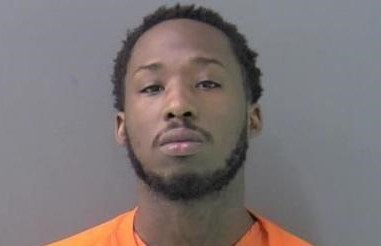

In [160]:
selectedIdx = 0
test_image(unseen[selectedIdx])
Image(filename=unseen[selectedIdx])

The tilt in the image is -15 degrees
The pan in the image is 90 degrees


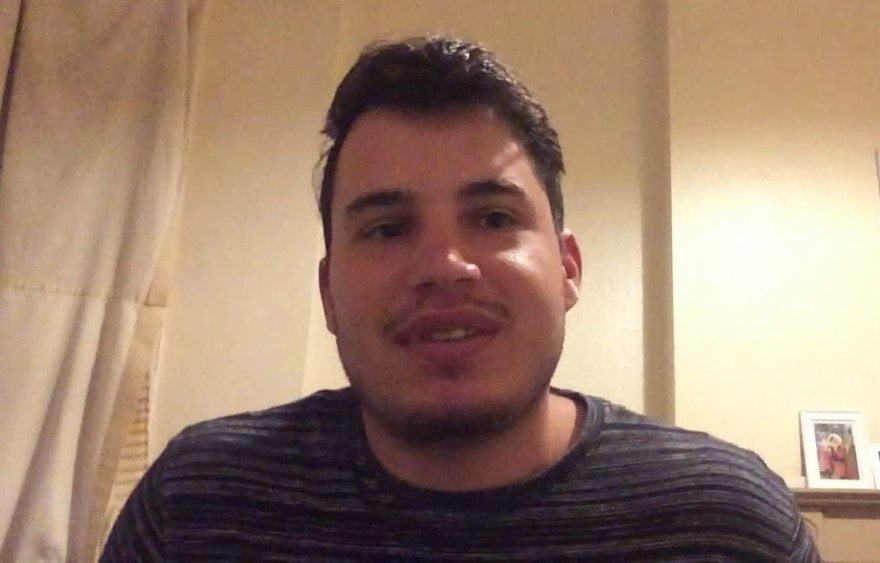

In [161]:
selectedIdx = 1
test_image(unseen[selectedIdx])
Image(filename=unseen[selectedIdx])

The tilt in the image is -15 degrees
The pan in the image is 15 degrees


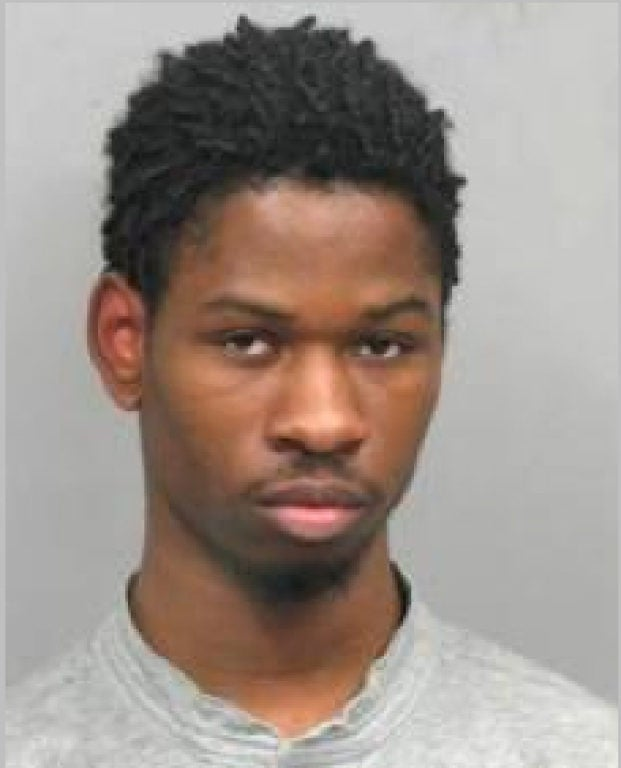

In [162]:
selectedIdx = 2
test_image(unseen[selectedIdx])
Image(filename=unseen[selectedIdx])